In [33]:
# Frequency response as bode plot using scipy and matplotlib
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import control as ct
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import control.matlab as cm
import scipy.signal as sg
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib.gridspec as gridspec
import cmath


# Define the transfer function
num = [1]
den = [1, 3, 2]
system = signal.TransferFunction(num, den)

def plot_bode(system, fmin=20, fmax=20000, num_points=2000):
    """
    Plot Bode of a *discrete* system (dlti) over [fmin, fmax] in Hz.
    """
    fs = 1.0 / system.dt  # sampling rate from the system
    # digital rad/sample grid corresponding to chosen Hz
    f = np.logspace(np.log10(fmin), np.log10(fmax), num_points)
    w = 2*np.pi*f/fs  # rad/sample

    # Discrete frequency response
    w, h = signal.dfreqresp(system, w=w)

    mag = 20*np.log10(np.maximum(np.abs(h), 1e-15))
    phase = np.unwrap(np.angle(h)) * 180/np.pi

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
    ax1.semilogx(f, mag)
    ax1.set_title('Bode Plot (discrete)')
    ax1.set_ylabel('Magnitude (dB)')
    ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

    ax2.semilogx(f, phase)
    ax2.set_ylabel('Phase (degrees)')
    ax2.set_xlabel('Frequency (Hz)')
    ax2.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()


# Test the bode plot function
plot_bode(system)





TypeError: unsupported operand type(s) for /: 'float' and 'NoneType'

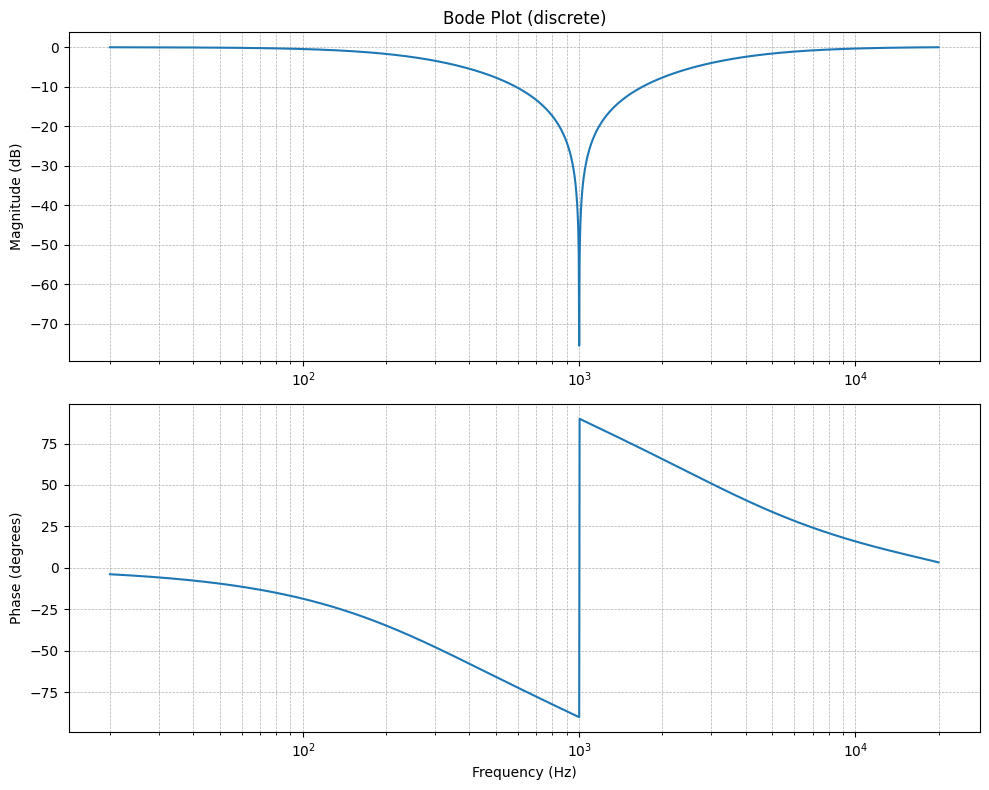

In [45]:
# Define a function that can create biquad parametric equalizer filter
def design_biquad(filter_type, f0, fs, Q=np.sqrt(0.5), gain_db=0.0, S=1.0):
    A = 10 ** (gain_db / 40.0)
    w0 = 2.0 * np.pi * f0 / fs
    cosw0 = np.cos(w0)
    sinw0 = np.sin(w0)

    if filter_type in {"lowshelf", "highshelf"}:
        alpha = sinw0 / 2.0 * np.sqrt((A + 1/A) * (1.0 / S - 1.0) + 2.0)
    else:
        alpha = sinw0 / (2.0 * Q)

    if filter_type == "peaking":
        b0 = 1 + alpha * A;  b1 = -2 * cosw0;  b2 = 1 - alpha * A
        a0 = 1 + alpha / A;  a1 = -2 * cosw0;  a2 = 1 - alpha / A
    elif filter_type == "notch":
        b0 = 1;              b1 = -2 * cosw0;  b2 = 1
        a0 = 1 + alpha;      a1 = -2 * cosw0;  a2 = 1 - alpha
    elif filter_type == "bandpass":  # RBJ constant-skirt, peak gain = Q
        b0 =  alpha;         b1 = 0.0;         b2 = -alpha
        a0 = 1 + alpha;      a1 = -2 * cosw0;  a2 = 1 - alpha
    elif filter_type == "lowpass":
        b0 = (1 - cosw0) / 2.0;  b1 = 1 - cosw0;  b2 = (1 - cosw0) / 2.0
        a0 = 1 + alpha;          a1 = -2 * cosw0; a2 = 1 - alpha
    elif filter_type == "highpass":
        b0 = (1 + cosw0) / 2.0;  b1 = -(1 + cosw0); b2 = (1 + cosw0) / 2.0
        a0 = 1 + alpha;          a1 = -2 * cosw0;  a2 = 1 - alpha
    elif filter_type == "allpass":
        b0 = 1 - alpha;      b1 = -2 * cosw0;  b2 = 1 + alpha
        a0 = 1 + alpha;      a1 = -2 * cosw0;  a2 = 1 - alpha
    elif filter_type == "lowshelf":
        sqrtA = np.sqrt(A)
        b0 = A*((A+1) - (A-1)*cosw0 + 2*sqrtA*alpha)
        b1 = 2*A*((A-1) - (A+1)*cosw0)
        b2 = A*((A+1) - (A-1)*cosw0 - 2*sqrtA*alpha)
        a0 =    (A+1) + (A-1)*cosw0 + 2*sqrtA*alpha
        a1 = -2*((A-1) + (A+1)*cosw0)
        a2 =    (A+1) + (A-1)*cosw0 - 2*sqrtA*alpha
    elif filter_type == "highshelf":
        sqrtA = np.sqrt(A)
        b0 = A*((A+1) + (A-1)*cosw0 + 2*sqrtA*alpha)
        b1 = -2*A*((A-1) + (A+1)*cosw0)
        b2 = A*((A+1) + (A-1)*cosw0 - 2*sqrtA*alpha)
        a0 =    (A+1) - (A-1)*cosw0 + 2*sqrtA*alpha
        a1 =  2*((A-1) - (A+1)*cosw0)
        a2 =    (A+1) - (A-1)*cosw0 - 2*sqrtA*alpha
    else:
        raise ValueError(f"Unknown filter_type: {filter_type}")

    # Normalize to a0 = 1
    b = np.array([b0, b1, b2], dtype=float) / a0
    a = np.array([1.0, a1/a0, a2/a0], dtype=float)

    # Return a DISCRETE LTI with the sampling period
    return signal.dlti(b, a, dt=1.0/fs)


# Example usage of parametric_eq function
fs = 48000  # Sampling frequency
f0 = 1000   # Center frequency
Q = 10      # Quality factor
gain_db = 6 # Gain in dB
filter_test = design_biquad("notch", f0, fs, 0.3, gain_db)

# Plot the Bode plot of the parametric equalizer filter
plot_bode(filter_test, fmin=20, fmax=20000)


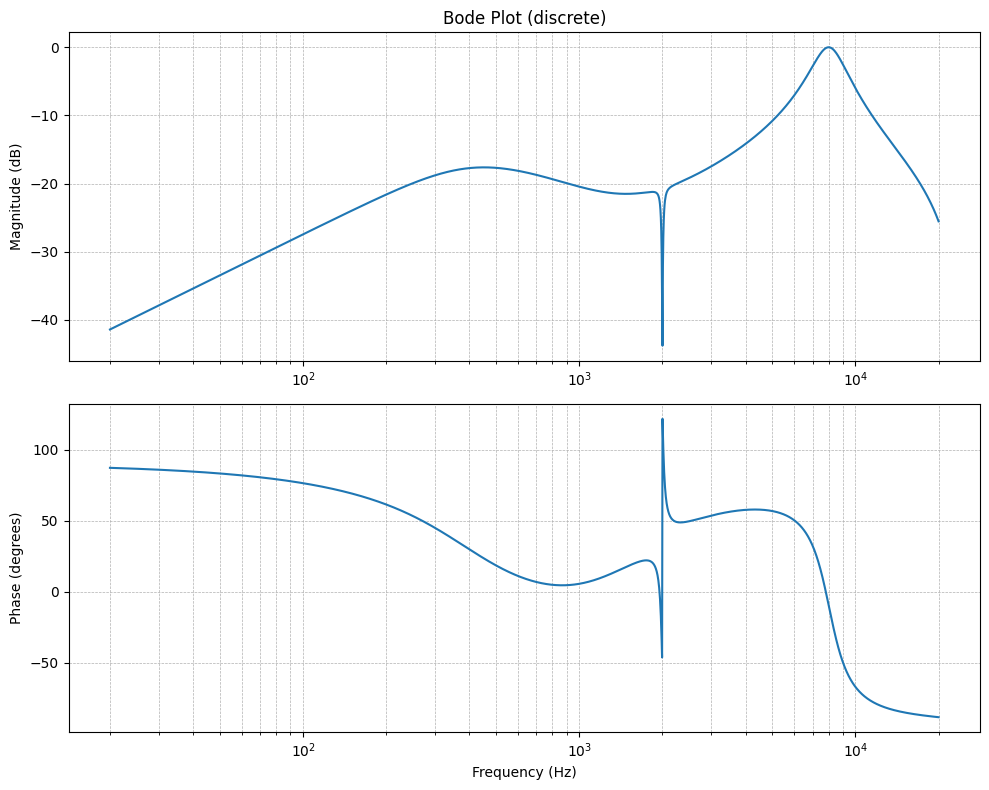

In [65]:
# Create a function that takes a series of filters and chains them together into a single transfer function
def chain_filters(filters):
    """
    Chain multiple discrete filters (dlti) together into a single dlti.
    """
    if not filters:
        raise ValueError("No filters to chain.")

    # Start with the first filter
    b_total = filters[0].num
    a_total = filters[0].den

    # Convolve numerator and denominator of each filter
    for filt in filters[1:]:
        b_total = np.convolve(b_total, filt.num)
        a_total = np.convolve(a_total, filt.den)

    # Return the combined filter as a dlti
    return signal.dlti(b_total, a_total, dt=filters[0].dt)


# Create a notch and a bandpass filter and chain them together
notch  = design_biquad("notch", 2000, fs, 30, 2)
bandpass_filter = design_biquad("bandpass", 8000, fs, 3, 2)
bassboost_filter = design_biquad("lowshelf", 1000, fs, 30, 15) 
bassboost_filter2 = design_biquad("lowshelf", 500, fs, 33, 6) 

combined_filter = chain_filters([notch, bandpass_filter, bassboost_filter, bassboost_filter2])

# Plot the Bode plot of the combined filter
plot_bode(combined_filter, fmin=20, fmax=20000)

In [ ]:
# Load 15 seconds of an audiosignal and apply the combined filter to it
from scipy.io import wavfile
fs_audio, audio_data = wavfile.read('../original_segment.wav')
filtered_audio = signal.dlsim(combined_filter, audio_data)
wavfile.write('filtered_segmented.wav', fs_audio, filtered_audio[1].astype(np.int16))

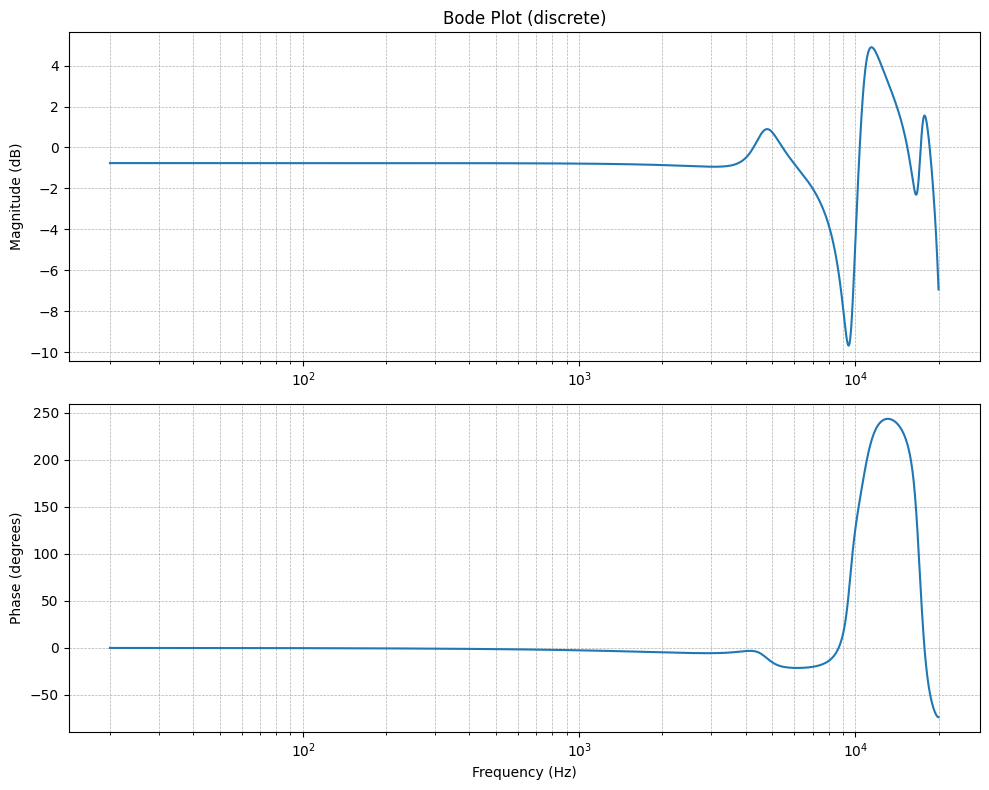

In [67]:
# Generate a random frequency response that could emulate a speaker
num_speaker = np.random.rand(10)
den_speaker = np.random.rand(10)
speaker_emulation_filter = signal.dlti(num_speaker, den_speaker, dt=1.0/fs)
#plot speaker response
plot_bode(speaker_emulation_filter, fmin=20, fmax=20000)

Optimized parameters (f0, Q, gain_db): [ 9.99604774e+02  1.04777508e+00 -1.86957434e-16]


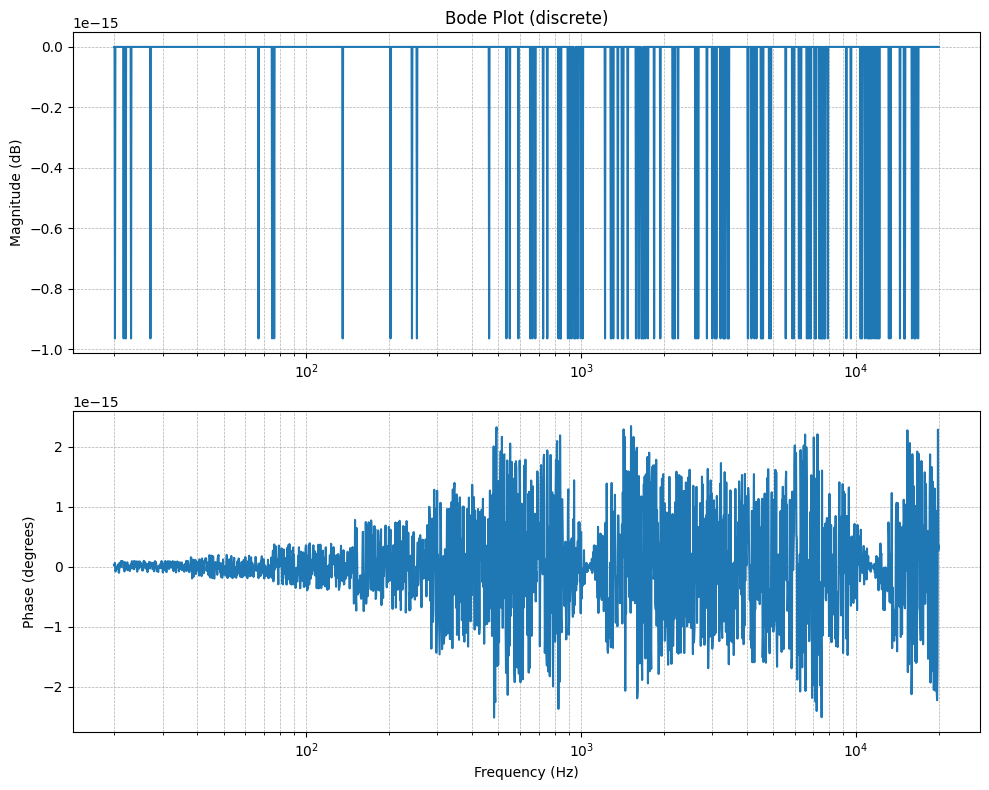

In [69]:
# Optimization algorithm to tune the filter parameters to match a desired frequency response of the speaker. The frequency response should be as close to flat as possible
def optimize_filter(target_response, initial_params, fs, filter_type="peaking", iterations=1000, learning_rate=0.01):
    from scipy.optimize import minimize

    def cost_function(params):
        f0_p, Q_p, gain_db_p = params
        test_filter = design_biquad(filter_type, f0_p, fs, Q_p, gain_db_p)

        # Build a frequency vector that matches the length of target_response
        # Use the same frequency range used elsewhere (20 Hz to 20 kHz or up to Nyquist)
        fmax = min(fs / 2.0, 20000.0)
        f = np.logspace(np.log10(20.0), np.log10(fmax), len(target_response))
        w = 2.0 * np.pi * f / fs  # rad/sample expected by dfreqresp

        _, h = signal.dfreqresp(test_filter, w=w)
        h = np.squeeze(h)  # ensure 1D
        mag = 20.0 * np.log10(np.maximum(np.abs(h), 1e-15))

        # Ensure shapes match (safety)
        if mag.shape != target_response.shape:
            # interpolate or resample mag to match target_response length if needed
            mag = np.interp(np.linspace(0, 1, len(target_response)),
                            np.linspace(0, 1, len(mag)),
                            mag)

        return np.sum((mag - target_response) ** 2)

    result = minimize(cost_function, initial_params, method='Nelder-Mead', options={'maxiter': iterations})
    return result.x  # optimized parameters


# Example usage of optimization
fs = 48000
f0 = 1000
initial_Q = 1
initial_gain_db = 0
initial_params = [f0, initial_Q, initial_gain_db]
target_response = np.zeros(2000)  # flat response in dB
optimized_params = optimize_filter(target_response, initial_params, fs)
print("Optimized parameters (f0, Q, gain_db):", optimized_params)
Q = optimized_params[1]
gain_db = optimized_params[2]
filter_test = design_biquad("peaking", f0, fs, Q, gain_db)

# Plot the Bode plot of the parametric equalizer filter
plot_bode(filter_test)


In [1]:
import numpy as np
import soundfile as sf


def main():
    fs = 48000
    pink = generate_pink_noise(duration_s=10.0, fs=fs, rms=0.05, random_state=42)

    sf.write("pink_noise.wav", pink, fs)


def generate_pink_noise(duration_s=5.0, fs=48000, rms=0.1, random_state=None):
    """
    Generate pink (1/f) noise using frequency-domain shaping.

    Parameters
    ----------
    duration_s : float
        Length of the signal in seconds.
    fs : int
        Sample rate in Hz.
    rms : float
        Target RMS level of the output signal.
    random_state : int or None
        Seed for reproducibility.

    Returns
    -------
    pink : np.ndarray
        1D array of pink noise samples (float32).
    """
    if random_state is not None:
        rng = np.random.default_rng(random_state)
    else:
        rng = np.random.default_rng()

    N = int(duration_s * fs)

    # White noise
    white = rng.standard_normal(N)

    # FFT of white noise
    freqs = np.fft.rfftfreq(N, d=1.0 / fs)
    White = np.fft.rfft(white)

    # Build 1/sqrt(f) filter (pink). Avoid division by zero at DC.
    # Set DC (freq=0) to 0 so we don't get a huge DC component.
    S = np.ones_like(freqs)
    S[1:] = 1.0 / np.sqrt(freqs[1:])
    S[0] = 0.0

    Pink = White * S

    # Back to time domain
    pink = np.fft.irfft(Pink, n=N)

    # Normalize to desired RMS
    current_rms = np.sqrt(np.mean(pink**2))
    if current_rms > 0:
        pink = pink * (rms / current_rms)

    return pink.astype(np.float32)


if __name__ == "__main__":
    main()